# Building metacells with [SEACell](https://github.com/dpeerlab/SEACells)

An example of building *metacells* using the [SEACell](https://github.com/dpeerlab/SEACells) algorithm. 
 
**Data:** cell lines scRNA-seq from [Tian et. al, 2019](https://doi.org/10.1038/s41592-019-0425-8), the same as for the [first tutorial](https://github.com/GfellerLab/SIB_workshop/blob/main/workbooks/Workbook_1__cancer_cell_lines).

*.h5ad* anndata file with scRNA-seq data is located in `'data/cell_lines/anndata_filtered.h5ad'`

For the complete tutorial of metacell construction with the [SEACell](https://github.com/dpeerlab/SEACells), please, follow author's [tutorial](https://github.com/dpeerlab/SEACells/blob/main/notebooks/SEACell_computation.ipynb) and the [readme](https://github.com/dpeerlab/SEACells/blob/main/README.md) for installation.


## Imports

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc


import SEACells
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('../../Py/') # make a MC_metrics.py script to stote metric functions
import mc_QC

## Parameter
Requested graining level

In [4]:
I = 3
gamma = [10, 20, 50, 75, 100][I] # graining level
gamma


75

## Load data

In [5]:
# Load data pre-filtered data
proj_name = "cell_lines"
data_folder = os.path.join("../../data/", proj_name)
ad = sc.read(os.path.join(data_folder, "anndata_filtered.h5ad"))

## Data processing 
In contrast to [Metacell-2](), SEACells build metacells based on processed data and takes as an input dimensionally reduced data (i.e., PCA for scRNA-seq data). Thus, we first compute PCA for our data usign the same set of genes used in the main [tutorial]()

In [6]:
# Save count as a separate layer
ad.layers['counts'] = ad.X

# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.layers['counts'])
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [7]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1000)

# set HVG manually (to be consistent with the main tutorial). If you want to use the HVG set computed by Scanpy, comment this line
ad.var['highly_variable'] = ad.var['use_for_SC_construction'].copy()

In [8]:
# Compute principal components - 
# Here we use 10 components to be consistent with out main tutorial, but fill free to explore other number of principal components to use 

n_comp    = 10
sc.tl.pca(ad, n_comps=n_comp, use_highly_variable=True)

# Compute UMAP for visualization 
sc.pp.neighbors(ad, n_neighbors=10, n_pcs=n_comp)
sc.tl.umap(ad)

## Computing metacells 

In [9]:
## User defined parameters
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data
## Additional parameters
n_waypoint_eigs = 10      # Number of eigenvalues to consider when initializing metacells
waypoint_proportion = 0.9 # Proportion of metacells to initialize using waypoint analysis, 
                          # the remainder of cells are selected by greedy selection
    
n_iter = 20

In [10]:
# The number of SEACells is computed as a ratio between the number of single cells and the desired graining level
n_SEACells = int(ad.shape[0]/gamma) 

model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)


Welcome to SEACells!


Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/3822 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/3822 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/3822 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 43 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 485.83it/s]

Selecting 7 cells from greedy initialization.


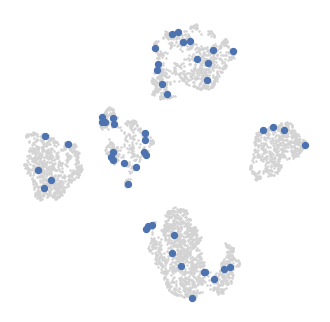

In [11]:
model.construct_kernel_matrix()
M = model.kernel_matrix

# Initialize archetypes
model.initialize_archetypes()
    
# Plot the initilization to ensure they are evenly spread
SEACells.plot.plot_initialization(ad, model, plot_basis='X_umap')

In [12]:
model.fit(min_iter=10, max_iter=n_iter)
    
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Randomly initialized A matrix.
Setting convergence threshold at 0.00108
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.
Ran for 21 iterations
Ran for 26 iterations


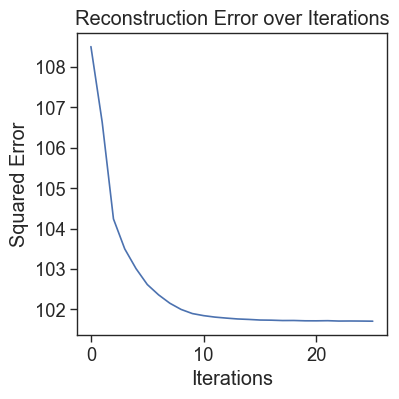

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 121.36it/s]


In [13]:
# Check for convergence 
model.plot_convergence()
    
membership = model.get_hard_assignments()
    
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
    

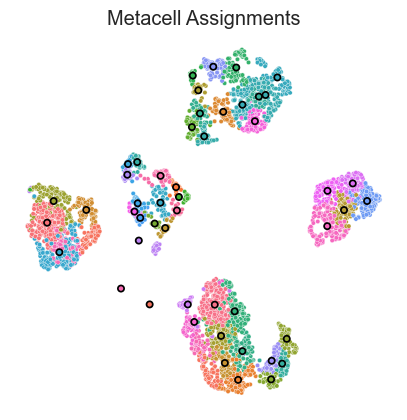

In [14]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

In [15]:
d = {x: i+1 for i, x in enumerate(SEACell_ad.obs_names)}
# make a membership (as in SCimplify() from SuperCell) vector
ad.obs.merge(membership)
ad.obs['membership'] = [d[x] for x in membership.SEACell]
print(ad.obs)


            cell_line demuxlet_cls  n_counts     SEACell  membership
index                                                               
Lib90_00000    HCC827          SNG  103148.0  SEACell-40           1
Lib90_00002      H838          SNG   92978.0  SEACell-35           2
Lib90_00003    HCC827          SNG   88660.0  SEACell-17           3
Lib90_00004    HCC827          SNG   86727.0  SEACell-40           1
Lib90_00005    HCC827          SNG   81103.0  SEACell-17           3
...               ...          ...       ...         ...         ...
Lib90_04026    HCC827          SNG    5985.0   SEACell-6           7
Lib90_04028      A549          SNG    5885.0  SEACell-27          36
Lib90_04029      A549          SNG    5096.0  SEACell-30          50
Lib90_04048      A549          SNG    5545.0  SEACell-28          29
Lib90_04057      H838          SNG    5458.0  SEACell-26          11

[3822 rows x 5 columns]


In [16]:
## Save single-cell metadata (i.e., `ad.obs` dataframe) in the seacell adata object
SEACell_ad.uns = ad.uns.copy()
SEACell_ad.uns['sc.obs'] = ad.obs.copy()

SEACell_ad.var['feature_gene'] = ad.var['highly_variable'].astype(int)
SEACell_ad.obs = SEACell_ad.obs.join(pd.DataFrame.from_dict(d, orient='index', columns=['membership']))
SEACell_ad.obs['gamma'] = gamma
SEACell_ad.obs['gamma_obtained'] = round(ad.shape[0]/SEACell_ad.shape[0])
SEACell_ad.obs['MC_tool'] = "SEACell"


SEACell_ad.obs

,membership,gamma,gamma_obtained,MC_tool
SEACell-40,1,75,76,SEACell
SEACell-35,2,75,76,SEACell
SEACell-17,3,75,76,SEACell
SEACell-31,4,75,76,SEACell
SEACell-46,5,75,76,SEACell
SEACell-49,6,75,76,SEACell
SEACell-6,7,75,76,SEACell
SEACell-34,8,75,76,SEACell
SEACell-43,9,75,76,SEACell
SEACell-39,10,75,76,SEACell


In [17]:
SEACell_ad.X.A

array([[3.0000e+00, 3.5700e+02, 4.0000e+01, ..., 1.8235e+04, 2.9200e+02,
        1.8000e+01],
       [1.1000e+01, 1.8800e+02, 7.5000e+01, ..., 1.0580e+03, 2.0000e+00,
        2.4000e+01],
       [4.0000e+00, 2.3600e+02, 5.1000e+01, ..., 9.2280e+03, 1.8200e+02,
        2.1000e+01],
       ...,
       [1.0000e+00, 7.0000e+00, 4.0000e+00, ..., 5.2000e+01, 0.0000e+00,
        2.0000e+00],
       [4.0000e+00, 5.2000e+01, 1.6000e+01, ..., 5.9000e+02, 1.0000e+00,
        7.0000e+00],
       [3.0000e+00, 2.9000e+01, 1.4000e+01, ..., 3.4800e+02, 0.0000e+00,
        3.0000e+00]])

In [18]:
SEACell_ad.uns['sc.obs']

,cell_line,demuxlet_cls,n_counts,SEACell,membership
index,,,,,
Lib90_00000,HCC827,SNG,103148.0,SEACell-40,1
Lib90_00002,H838,SNG,92978.0,SEACell-35,2
Lib90_00003,HCC827,SNG,88660.0,SEACell-17,3
Lib90_00004,HCC827,SNG,86727.0,SEACell-40,1
Lib90_00005,HCC827,SNG,81103.0,SEACell-17,3
...,...,...,...,...,...
Lib90_04026,HCC827,SNG,5985.0,SEACell-6,7
Lib90_04028,A549,SNG,5885.0,SEACell-27,36
Lib90_04029,A549,SNG,5096.0,SEACell-30,50


### Metacell quality metrics 

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


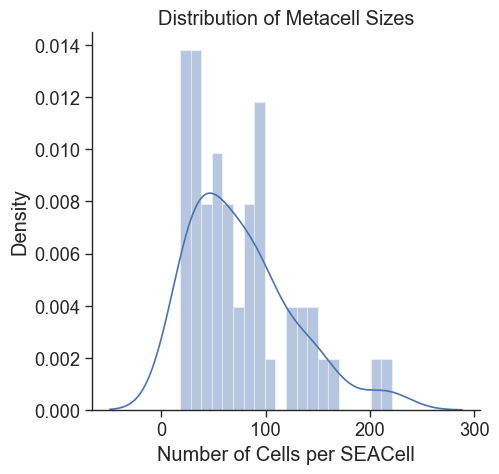

,membership,gamma,gamma_obtained,MC_tool,size
SEACell-40,1,75,76,SEACell,139
SEACell-35,2,75,76,SEACell,83
SEACell-17,3,75,76,SEACell,95
SEACell-31,4,75,76,SEACell,37
SEACell-46,5,75,76,SEACell,94
SEACell-49,6,75,76,SEACell,94
SEACell-6,7,75,76,SEACell,145
SEACell-34,8,75,76,SEACell,89
SEACell-43,9,75,76,SEACell,33
SEACell-39,10,75,76,SEACell,37


In [19]:
mc_size = SEACells.plot.plot_SEACell_sizes(ad, bins=20)

SEACell_ad.obs = pd.merge(SEACell_ad.obs, mc_size, left_index=True, right_index=True)
SEACell_ad.obs

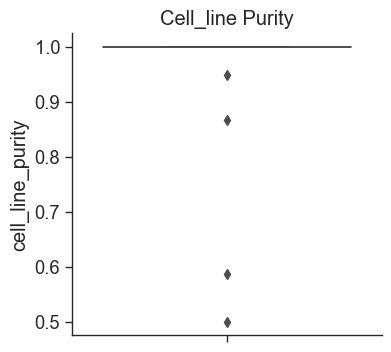

In [20]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'cell_line')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='cell_line_purity')
plt.title('Cell_line Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

SEACell_ad.obs = pd.merge(SEACell_ad.obs, SEACell_purity, left_index=True, right_index=True)


In [21]:
SEACell_ad.obs = SEACell_ad.obs.iloc[:,:7]
SEACell_ad.obs
n_comp

10

In [22]:
import importlib
importlib.reload(mc_QC)

compactness_PCA = mc_QC.compactness(ad, 'X_pca', DO_DC = False, name = 'Compactness_PCA', n_comp=n_comp)['Compactness_PCA']
compactness_DC  = mc_QC.compactness(ad, 'X_pca', DO_DC = True, name = 'Compactness_DC', n_comp=n_comp)['Compactness_DC']

SEACell_ad.obs = SEACell_ad.obs.join(compactness_PCA)
SEACell_ad.obs = SEACell_ad.obs.join(compactness_DC)

separation_PCA = mc_QC.separation(ad, 'X_pca', DO_DC = False, name = 'Separation_PCA', n_comp=n_comp)['Separation_PCA']
separation_DC  = mc_QC.separation(ad, 'X_pca', DO_DC = True, name = 'Separation_DC', n_comp=n_comp)['Separation_DC']

SEACell_ad.obs = SEACell_ad.obs.join(separation_PCA)
SEACell_ad.obs = SEACell_ad.obs.join(separation_DC)

SEACell_ad.obs


Determing nearest neighbor graph...
Determing nearest neighbor graph...


,membership,gamma,gamma_obtained,MC_tool,size,cell_line,cell_line_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC
SEACell-40,1,75,76,SEACell,139,HCC827,1.000000,1.954103,0.007409,4.960405,0.334123
SEACell-35,2,75,76,SEACell,83,H838,1.000000,2.091270,0.006590,5.569157,0.645291
SEACell-17,3,75,76,SEACell,95,HCC827,1.000000,2.196646,0.041732,5.370686,0.615710
SEACell-31,4,75,76,SEACell,37,H1975,1.000000,2.084569,0.052692,4.457351,0.432820
SEACell-46,5,75,76,SEACell,94,HCC827,1.000000,1.425062,0.005921,4.960405,0.334123
SEACell-49,6,75,76,SEACell,94,H838,1.000000,0.976839,0.010973,3.798340,0.429349
SEACell-6,7,75,76,SEACell,145,HCC827,1.000000,4.567539,0.919436,7.028227,1.875877
SEACell-34,8,75,76,SEACell,89,H838,1.000000,1.170397,0.021026,3.798340,0.429349
SEACell-43,9,75,76,SEACell,33,H1975,1.000000,1.386777,0.020062,3.602730,0.170908
SEACell-39,10,75,76,SEACell,37,H1975,1.000000,1.467419,0.056969,3.991212,0.301863


In [23]:
# compute extra PC to evaluate performance of compactness and separation outside the n_comp used for MC construction
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)
ad.obsm['X_pca'].shape

(3822, 50)

### Compute *compactness* for a range of latent space components 

In [24]:
QC_compactness = pd.DataFrame()

# Compactness

for n_comp_i in range(2, 31, 2):
    print(n_comp_i)
    
    compactness_PCA_i = mc_QC.compactness(ad, 'X_pca', n_comp = n_comp_i, DO_DC = False, MC_label = 'membership')
    compactness_DC_i  = mc_QC.compactness(ad, 'X_pca', n_comp = n_comp_i, DO_DC = True, MC_label = 'membership')
    
    QC_compactness = pd.concat([QC_compactness, compactness_PCA_i, compactness_DC_i], ignore_index=True)
QC_compactness


2
Determing nearest neighbor graph...
4
Determing nearest neighbor graph...
6
Determing nearest neighbor graph...
8
Determing nearest neighbor graph...
10
Determing nearest neighbor graph...
12
Determing nearest neighbor graph...
14
Determing nearest neighbor graph...
16
Determing nearest neighbor graph...
18
Determing nearest neighbor graph...
20
Determing nearest neighbor graph...
22
Determing nearest neighbor graph...
24
Determing nearest neighbor graph...
26
Determing nearest neighbor graph...
28
Determing nearest neighbor graph...
30
Determing nearest neighbor graph...


,compactness,low_dim_embedding,n_comp,membership
0,0.986614,X_pca,2,1
1,0.508202,X_pca,2,2
2,1.053280,X_pca,2,3
3,0.558712,X_pca,2,4
4,0.795248,X_pca,2,5
...,...,...,...,...
1495,0.003272,DC,30,46
1496,0.006018,DC,30,47
1497,0.003409,DC,30,48
1498,0.005307,DC,30,49


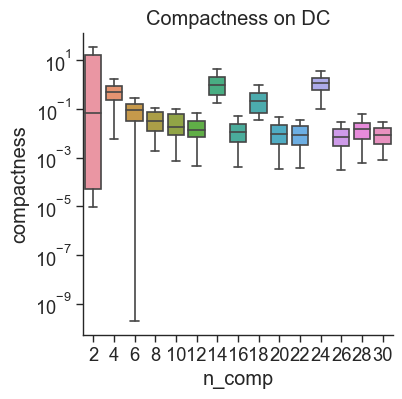

In [25]:

plt.figure(figsize=(4,4))
sns.boxplot(data=QC_compactness[QC_compactness.low_dim_embedding == 'DC'], y='compactness', x = 'n_comp', showfliers = False)
plt.yscale('log')
plt.title('Compactness on DC')
sns.despine()
plt.show()
plt.close()



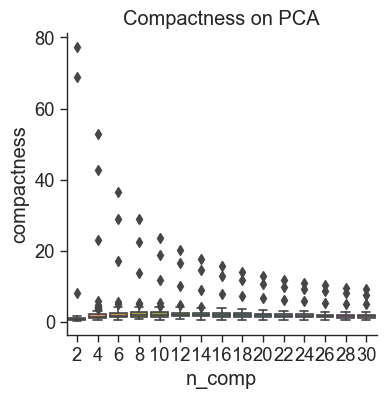

In [26]:
plt.figure(figsize=(4,4))
sns.boxplot(data=QC_compactness[QC_compactness.low_dim_embedding == 'X_pca'], y='compactness', x = 'n_comp')
#plt.yscale('log')
plt.title('Compactness on PCA')
sns.despine()
plt.show()
plt.close()

### Compute *separation* for a range of latent space components 

In [27]:
importlib.reload(mc_QC)
QC_separation = pd.DataFrame()

#Separation

for n_comp_i in range(2, 31, 2):
    print(n_comp_i)
    sep_PCA_i = mc_QC.separation(ad, 'X_pca', n_comp = n_comp_i, DO_DC = False, MC_label = 'membership')
    sep_DC_i = mc_QC.separation(ad, 'X_pca', n_comp = n_comp_i, DO_DC = True, MC_label = 'membership')
    
    
    QC_separation = pd.concat([QC_separation, sep_PCA_i, sep_DC_i], ignore_index=True)
QC_separation

2
Determing nearest neighbor graph...
4
Determing nearest neighbor graph...
6
Determing nearest neighbor graph...
8
Determing nearest neighbor graph...
10
Determing nearest neighbor graph...
12
Determing nearest neighbor graph...
14
Determing nearest neighbor graph...
16
Determing nearest neighbor graph...
18
Determing nearest neighbor graph...
20
Determing nearest neighbor graph...
22
Determing nearest neighbor graph...
24
Determing nearest neighbor graph...
26
Determing nearest neighbor graph...
28
Determing nearest neighbor graph...
30
Determing nearest neighbor graph...


,separation,low_dim_embedding,n_comp,membership
0,0.396366,X_pca,2,1
1,0.220653,X_pca,2,2
2,0.140260,X_pca,2,3
3,0.569174,X_pca,2,4
4,0.191992,X_pca,2,5
...,...,...,...,...
1495,0.000000,DC,30,46
1496,0.000000,DC,30,47
1497,0.000000,DC,30,48
1498,0.000000,DC,30,49


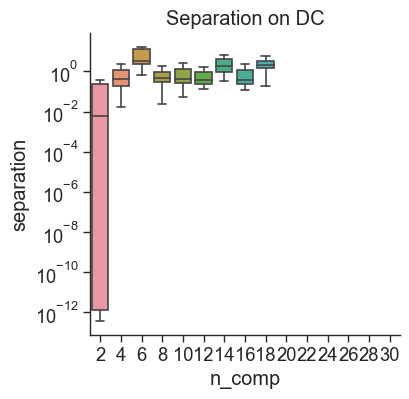

In [28]:
plt.figure(figsize=(4,4))
sns.boxplot(data=QC_separation[QC_separation.low_dim_embedding == 'DC'], y='separation', x = 'n_comp', showfliers = False)
plt.yscale('log')
plt.title('Separation on DC')
sns.despine()
plt.show()
plt.close()

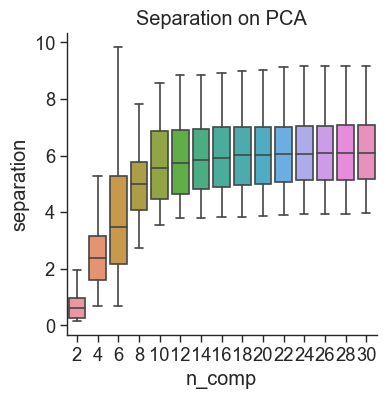

In [29]:
plt.figure(figsize=(4,4))
sns.boxplot(data=QC_separation[QC_separation.low_dim_embedding == 'X_pca'], y='separation', x = 'n_comp', showfliers = False)
#plt.yscale('log')
plt.title('Separation on PCA')
sns.despine()
plt.show()
plt.close()

In [30]:
QC = QC_compactness.merge(QC_separation, on=['low_dim_embedding', 'n_comp', 'membership'])

QC = SEACell_ad.obs.iloc[:,:7].merge(QC, on = 'membership')

QC

,membership,gamma,gamma_obtained,MC_tool,size,cell_line,cell_line_purity,compactness,low_dim_embedding,n_comp,separation
0,1,75,76,SEACell,139,HCC827,1.0,0.986614,X_pca,2,0.396366
1,1,75,76,SEACell,139,HCC827,1.0,23.617084,DC,2,0.067332
2,1,75,76,SEACell,139,HCC827,1.0,1.515456,X_pca,4,0.681080
3,1,75,76,SEACell,139,HCC827,1.0,0.122733,DC,4,0.058502
4,1,75,76,SEACell,139,HCC827,1.0,1.532437,X_pca,6,1.573632
...,...,...,...,...,...,...,...,...,...,...,...
1495,50,75,76,SEACell,50,A549,1.0,0.004449,DC,26,0.000000
1496,50,75,76,SEACell,50,A549,1.0,1.914337,X_pca,28,5.983341
1497,50,75,76,SEACell,50,A549,1.0,0.013214,DC,28,0.000000
1498,50,75,76,SEACell,50,A549,1.0,1.879790,X_pca,30,5.987603


Text(0.3, 0, 'r = 0.7323')

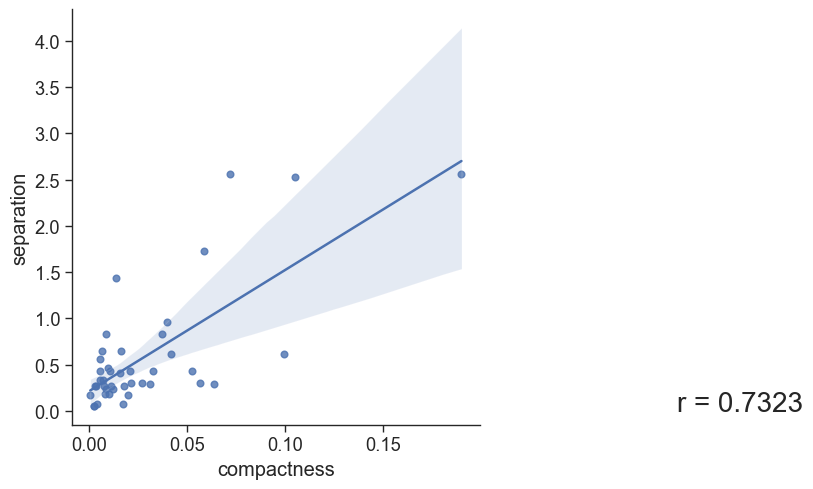

In [31]:
import scipy
df = QC[(QC['low_dim_embedding'] == 'DC') & (QC['n_comp'] == 10)]
#df['size'] = mc_size.cell_line
df = df[(df['separation']<100) & (df['compactness']<.2)]
r = df.compactness.corr(df.separation)

#sns.scatterplot(x="compactness", y="separation", data=df)
sns.lmplot(x="compactness", y="separation", data=df)

#add correlation coefficient to plot
plt.text(.3,0, 'r = ' + str(round(r, 4)), fontsize=20)


In [32]:
mc_INV = mc_QC.mc_inner_normalized_var(ad, 'SEACell')

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/pandas/core/arraylike.py:490: RuntimeWarning: divide by zero encountered in reciprocal
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [33]:
mc_INV_val = mc_INV.quantile([0.05, 0.5, 0.95], axis=1, numeric_only=True)
mc_INV_val = pd.DataFrame(mc_INV_val.transpose()).set_axis(['INV_5', 'INV_50','INV_95'], axis=1, inplace=False)
#mc_INV_val = pd.DataFrame.from_dict(mc_INV_val, orient='index', columns=['INV_95'])
SEACell_ad.obs = SEACell_ad.obs.join(mc_INV_val)

In [34]:
SEACell_ad.obs

,membership,gamma,gamma_obtained,MC_tool,size,cell_line,cell_line_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC,INV_5,INV_50,INV_95
SEACell-40,1,75,76,SEACell,139,HCC827,1.000000,1.954103,0.007409,4.960405,0.334123,0.000091,0.026992,0.318547
SEACell-35,2,75,76,SEACell,83,H838,1.000000,2.091270,0.006590,5.569157,0.645291,0.000161,0.033029,0.334418
SEACell-17,3,75,76,SEACell,95,HCC827,1.000000,2.196646,0.041732,5.370686,0.615710,0.000116,0.025725,0.310691
SEACell-31,4,75,76,SEACell,37,H1975,1.000000,2.084569,0.052692,4.457351,0.432820,0.000408,0.031901,0.364829
SEACell-46,5,75,76,SEACell,94,HCC827,1.000000,1.425062,0.005921,4.960405,0.334123,0.000081,0.023731,0.263036
SEACell-49,6,75,76,SEACell,94,H838,1.000000,0.976839,0.010973,3.798340,0.429349,0.000128,0.031253,0.250742
SEACell-6,7,75,76,SEACell,145,HCC827,1.000000,4.567539,0.919436,7.028227,1.875877,0.000165,0.030493,0.530424
SEACell-34,8,75,76,SEACell,89,H838,1.000000,1.170397,0.021026,3.798340,0.429349,0.000166,0.032282,0.273160
SEACell-43,9,75,76,SEACell,33,H1975,1.000000,1.386777,0.020062,3.602730,0.170908,0.000512,0.042289,0.418547
SEACell-39,10,75,76,SEACell,37,H1975,1.000000,1.467419,0.056969,3.991212,0.301863,0.000640,0.039502,0.366985


In [35]:
SEACell_ad.uns['QC_separation_compactness_PC_range'] = QC

## Saving data for the downstream analysis

In [36]:
SEACell_ad.write(os.path.join(data_folder, 'output', f'seacells_gamma_{gamma}.h5ad'))
SEACell_ad.obs.to_csv(os.path.join(data_folder, 'output', f'seacells_gamma_{gamma}_metacell_obs.csv'))
ad.obs.to_csv(os.path.join(data_folder, 'output', f'seacells_gamma_{gamma}_singlecell_obs.csv'))
QC.to_csv(os.path.join(data_folder, 'output', f'seacells_gamma_{gamma}_QC.csv'))
